In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
import datetime
from dateutil.relativedelta import relativedelta
import pickle as pck
from pmdarima.arima import auto_arima
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout


Having this "bitcoin" dataset with bitcoin pricing evolution from 2012 to September 9th of 2022 we'll analyze bitcoin prices and try different Time Series models to predict them

In [2]:
bitcoin = pd.read_csv("../data/bitcoin.csv")

In [3]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4437 entries, 0 to 4436
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Fecha     4437 non-null   object
 1   Último    4437 non-null   object
 2   Apertura  4437 non-null   object
 3   Máximo    4437 non-null   object
 4   Mínimo    4437 non-null   object
 5   Vol.      4437 non-null   object
 6   % var.    4437 non-null   object
dtypes: object(7)
memory usage: 242.8+ KB


In [4]:
bitcoin.describe()

Fecha Último Apertura Máximo Mínimo   Vol. % var.
count         4437   4437     4437   4437   4437   4437   4437
unique        4437   3485     3478   3470   3480   3965   1515
top     09.09.2022    0,1      0,1    0,1    0,1  1,05M  0,00%
freq             1    100      100     97    101      6    425

In [5]:
bitcoin.head()

Fecha    Último  Apertura    Máximo    Mínimo     Vol.  % var.
0  09.09.2022  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1  08.09.2022  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2  07.09.2022  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3  06.09.2022  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4  05.09.2022  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

We can see that "Fecha" is in descending order, so we need to change that

In [6]:
bitcoin.describe()

Fecha Último Apertura Máximo Mínimo   Vol. % var.
count         4437   4437     4437   4437   4437   4437   4437
unique        4437   3485     3478   3470   3480   3965   1515
top     09.09.2022    0,1      0,1    0,1    0,1  1,05M  0,00%
freq             1    100      100     97    101      6    425

In [7]:
fig = px.line(bitcoin, x="Fecha", y="Máximo")
fig.show()

The above plot shows the fluctuation of Bitcoin price in a strange way, due to the column "Fecha" being in descending order. We'll get it right and plot it again to see how prices have changed

In [8]:
bitcoin.columns = ["date", "close", "open", "high", "low", "vol", "var_%"]

In [9]:
bitcoin.head()

date      last      open      high       low      vol   var_%
0  09.09.2022  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1  08.09.2022  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2  07.09.2022  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3  06.09.2022  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4  05.09.2022  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

In [10]:
bitcoin["date"].describe()

count           4437
unique          4437
top       09.09.2022
freq               1
Name: date, dtype: object

Now let's change type of date to date time to work with time series

In [11]:
bitcoin["date"]= pd.to_datetime(bitcoin["date"], dayfirst=True)

In [12]:
bitcoin.head()

date      last      open      high       low      vol   var_%
0 2022-09-09  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1 2022-09-08  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2 2022-09-07  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3 2022-09-06  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4 2022-09-05  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

In [13]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4437 entries, 0 to 4436
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4437 non-null   datetime64[ns]
 1   last    4437 non-null   object        
 2   open    4437 non-null   object        
 3   high    4437 non-null   object        
 4   low     4437 non-null   object        
 5   vol     4437 non-null   object        
 6   var_%   4437 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 242.8+ KB


We see that every column, except date, is of type object when we know they should be floats. 
Let's clean the values with characters not needed and change the type of each column

In [14]:
num = bitcoin.drop("date", axis = 1)

In [15]:
num.head()

last      open      high       low      vol   var_%
0  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

In the cell below we replace the letters and symbols that we don't want

In [16]:
for i in num:
    for j in range(len(num)):
        num[i][j] = num[i][j].replace(".", "")
        num[i][j] = num[i][j].replace(",", ".")
        if "%" in num[i][j]:
            num[i][j] = num[i][j].replace("%", "")
        elif "K" in num[i][j]:
            num[i][j] = float(num[i][j].replace("K", ""))
        elif "M" in num[i][j]:
            num[i][j] = float(num[i][j].replace("M", "")) * 1000
            if num[i][j] > 15:
                num[i][j] = num[i][j] / 1000
        elif "B" in num[i][j]:
            num[i][j] = float(num[i][j].replace("B", "")) * 1000
        elif num[i][j] == "-":
            num[i][j] = 0
        else:
            pass

In [17]:
num.head()

last     open     high      low     vol  var_%
0  20742.8  19318.8  20743.7  19294.1   359.4   7.38
1  19317.4  19281.5  19444.7  19034.5  291.43   0.19
2  19281.5  18786.3  19445.9  18548.4   319.1   2.64
3  18786.4  19793.4  20169.3  18723.3  402.43  -5.09
4  19793.1  19999.9  20042.9  19650.7  238.71  -1.03

In [18]:
num = num.astype(float)

In [19]:
bitcoin[["close", "open", "high", "low", "vol", "var_%"]] = num

Now we sort the dates in descending order and take some values that don't add much to the total, I chose to keep values from 2012 onwards.

In [20]:
bitcoin = bitcoin.sort_values(by='date').reset_index(drop = True)

In [21]:
bitcoin = bitcoin[bitcoin["date"] >= "2012-01-01"]

In [22]:
bitcoin = bitcoin.set_index("date")

In [23]:
bitcoin.insert(loc = 0, column = "date", value = bitcoin.index)

In [24]:
bitcoin

date      last     open     high      low     vol  var_%  \
date                                                                        
2012-01-01 2012-01-01       5,3      4.7      5.5      4.6  108.51  11.65   
2012-01-02 2012-01-02       5,2      5.3      5.5      4.8   69.15  -0.95   
2012-01-03 2012-01-03       4,9      5.2      5.3      4.7  125.17  -6.51   
2012-01-04 2012-01-04       5,6      4.9      5.7      4.8  131.17  14.14   
2012-01-05 2012-01-05       6,9      5.6      7.2      5.6  182.33  24.78   
...               ...       ...      ...      ...      ...     ...    ...   
2022-09-05 2022-09-05  19.793,1  19999.9  20042.9  19650.7  238.71  -1.03   
2022-09-06 2022-09-06  18.786,4  19793.4  20169.3  18723.3  402.43  -5.09   
2022-09-07 2022-09-07  19.281,5  18786.3  19445.9  18548.4  319.10   2.64   
2022-09-08 2022-09-08  19.317,4  19281.5  19444.7  19034.5  291.43   0.19   
2022-09-09 2022-09-09  20.742,8  19318.8  20743.7  19294.1  359.40   7.38   

              close  
date                 
2012-01-01      5.3  
2012-01-02      5.2  
2012-01-03      4.9  
2012-01-04      5.6  
2012-01-05      6.9  
...             ...  
2022-09-05  19793.1  
2022-09-06  18786.4  
2022-09-07  19281.5  
2022-09-08  19317.4  
2022-09-09  20742.8  

[3905 rows x 8 columns]

Data is cleaned and date column in correct order. 
Next thing is to check if the dates follows the same frequency. That's important for any Time Series because the frequency must be constant

In [25]:
bit_2 = bitcoin.copy()

bit_2['date_shift'] = bit_2['date'].shift()  

In [26]:
bit_2.head()

date last  open  high  low     vol  var_%  close date_shift
date                                                                        
2012-01-01 2012-01-01  5,3   4.7   5.5  4.6  108.51  11.65    5.3        NaT
2012-01-02 2012-01-02  5,2   5.3   5.5  4.8   69.15  -0.95    5.2 2012-01-01
2012-01-03 2012-01-03  4,9   5.2   5.3  4.7  125.17  -6.51    4.9 2012-01-02
2012-01-04 2012-01-04  5,6   4.9   5.7  4.8  131.17  14.14    5.6 2012-01-03
2012-01-05 2012-01-05  6,9   5.6   7.2  5.6  182.33  24.78    6.9 2012-01-04

In [27]:
bit_2['diff'] = bit_2['date'] - bit_2['date_shift']

In [28]:
bit_2.head()

date last  open  high  low     vol  var_%  close date_shift  \
date                                                                           
2012-01-01 2012-01-01  5,3   4.7   5.5  4.6  108.51  11.65    5.3        NaT   
2012-01-02 2012-01-02  5,2   5.3   5.5  4.8   69.15  -0.95    5.2 2012-01-01   
2012-01-03 2012-01-03  4,9   5.2   5.3  4.7  125.17  -6.51    4.9 2012-01-02   
2012-01-04 2012-01-04  5,6   4.9   5.7  4.8  131.17  14.14    5.6 2012-01-03   
2012-01-05 2012-01-05  6,9   5.6   7.2  5.6  182.33  24.78    6.9 2012-01-04   

             diff  
date               
2012-01-01    NaT  
2012-01-02 1 days  
2012-01-03 1 days  
2012-01-04 1 days  
2012-01-05 1 days

In [29]:
bit_2[bit_2['diff'] != '1 days'].index 

DatetimeIndex(['2012-01-01'], dtype='datetime64[ns]', name='date', freq=None)

We see there are no values with a "diff" higher than "1 days", so we can say all values are following a daily frequency.
The NaT in first row is expected, since there is no value previous to the first one. 

We plot again tha data to see how it has changed.

In [30]:
fig = px.line(bitcoin, x="date", y="close")
fig.show()

There are many differences from the first one, but still, there is a big tail at the beginning that we may not need. In the following models we'll try different approaches with more or less data depending on what we see necessary and will see what works best of each approach

In [31]:
bitcoin_1 = bitcoin[bitcoin["date"] >= "2017-01-01"]
bitcoin.head()

date last  open  high  low     vol  var_%  close
date                                                             
2012-01-01 2012-01-01  5,3   4.7   5.5  4.6  108.51  11.65    5.3
2012-01-02 2012-01-02  5,2   5.3   5.5  4.8   69.15  -0.95    5.2
2012-01-03 2012-01-03  4,9   5.2   5.3  4.7  125.17  -6.51    4.9
2012-01-04 2012-01-04  5,6   4.9   5.7  4.8  131.17  14.14    5.6
2012-01-05 2012-01-05  6,9   5.6   7.2  5.6  182.33  24.78    6.9

In [32]:
fig = px.line(bitcoin_1, x="date", y="close")
fig.show()

Here we see in more detail the evolution from 2017 to 2022

In [33]:
bitcoin_17 = bitcoin_1[bitcoin_1["date"] < "2018-01-01"]
bitcoin_18 = bitcoin_1[(bitcoin_1["date"] > "2018-01-01") & (bitcoin_1["date"] < "2019-01-01")]
bitcoin_19 = bitcoin_1[(bitcoin_1["date"] > "2019-01-01") & (bitcoin_1["date"] < "2020-01-01")]
bitcoin_20 = bitcoin_1[(bitcoin_1["date"] > "2020-01-01") & (bitcoin_1["date"] < "2021-01-01")]
bitcoin_21 = bitcoin_1[(bitcoin_1["date"] > "2021-01-01") & (bitcoin_1["date"] < "2022-01-01")]
bitcoin_22 = bitcoin_1[(bitcoin_1["date"] > "2022-01-01")]

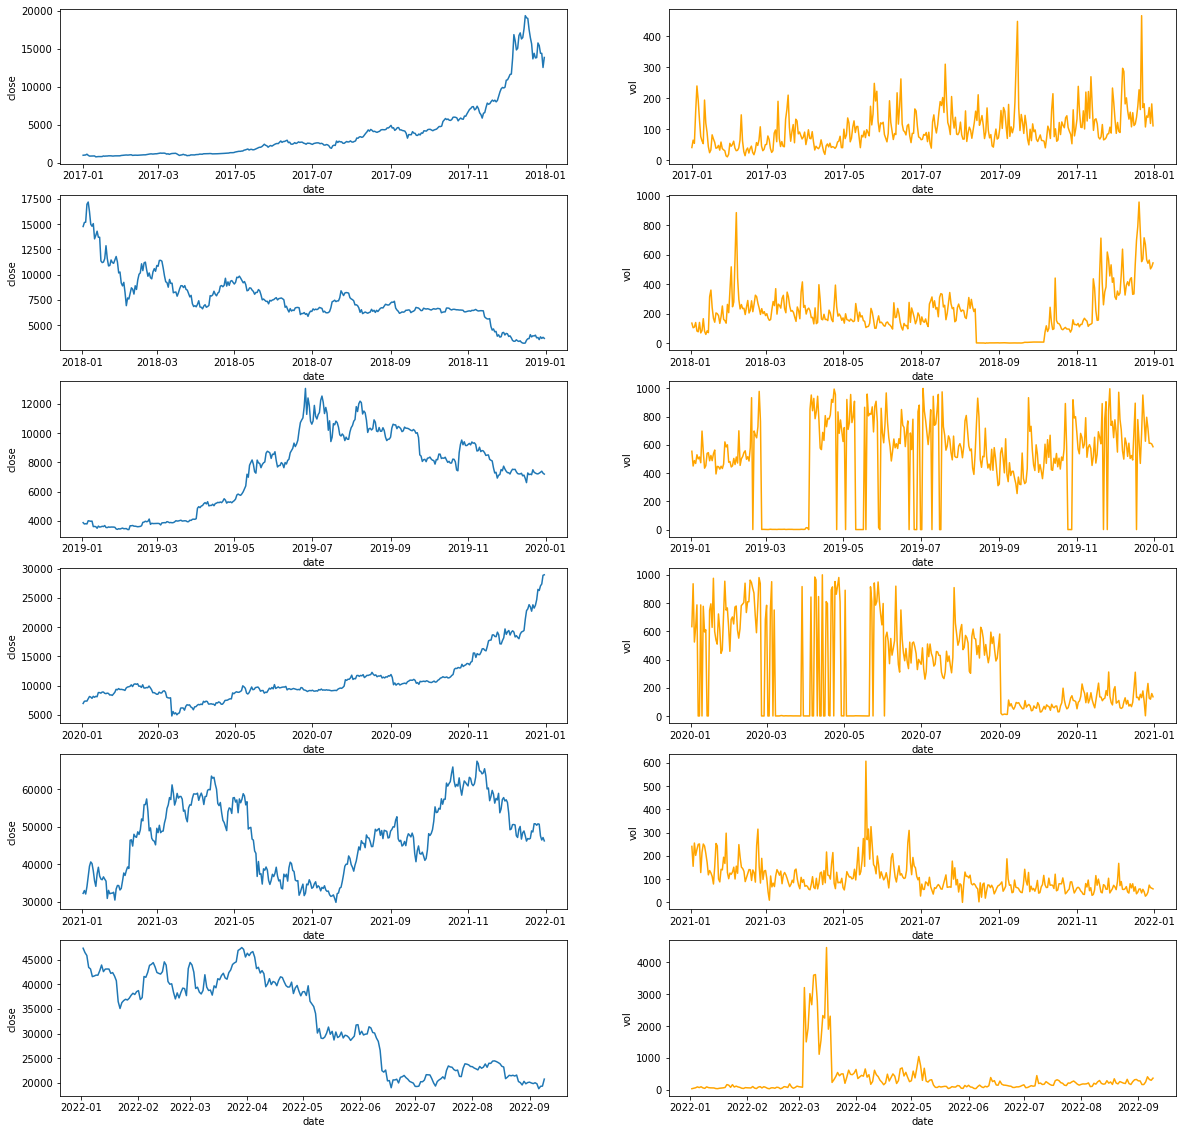

In [34]:
fig, axes = plt.subplots(6, 2, figsize = (20, 20))

sns.lineplot(data = bitcoin_17, y = "close", x = "date", ax = axes[0, 0])
sns.lineplot(data = bitcoin_17, y = "vol", x = "date", color = "orange", ax = axes[0, 1])
sns.lineplot(data = bitcoin_18, y = "close", x = "date", ax = axes[1, 0])
sns.lineplot(data = bitcoin_18, y = "vol", x = "date", color = "orange", ax = axes[1, 1])
sns.lineplot(data = bitcoin_19, y = "close", x = "date", ax = axes[2, 0])
sns.lineplot(data = bitcoin_19, y = "vol", x = "date", color = "orange", ax = axes[2, 1])
sns.lineplot(data = bitcoin_20, y = "close", x = "date", ax = axes[3, 0])
sns.lineplot(data = bitcoin_20, y = "vol", x = "date", color = "orange", ax = axes[3, 1])
sns.lineplot(data = bitcoin_21, y = "close", x = "date", ax = axes[4, 0])
sns.lineplot(data = bitcoin_21, y = "vol", x = "date", color = "orange", ax = axes[4, 1])
sns.lineplot(data = bitcoin_22, y = "close", x = "date", ax = axes[5, 0])
sns.lineplot(data = bitcoin_22, y = "vol", x = "date", color = "orange", ax = axes[5, 1])

plt.show()


In the plots above we see the price of bitcoin during each year from 2017 to the present day and the volume of transactiones made in the same period. On the right side, the volumes, show a higher number of transactions, at least more constant in the past two years. Also we can see that each peak of transactions are result of a drop on the prices or significant increase. 

In [35]:
bitcoin.shape

(3905, 8)

In [36]:
bitcoin.to_csv('../data/clean_data.csv')

We are going to use the values from column "close" to predict the future results.

In [37]:
bitcoin_close = bitcoin[["close"]]

In [38]:
bitcoin_close.head()

close
date             
2012-01-01    5.3
2012-01-02    5.2
2012-01-03    4.9
2012-01-04    5.6
2012-01-05    6.9

#### STATIONARITY

In [39]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags = "auto") 
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [41]:
adf_test(bitcoin_close["close"])

Results of Dickey-Fuller Test:
Test Statistic                   -1.615436
p-value                           0.475123
#Lags Used                       29.000000
Number of Observations Used    3875.000000
Critical Value (1%)              -3.432039
Critical Value (5%)              -2.862286
Critical Value (10%)             -2.567167
dtype: float64


From adf_test we see there is no stationarity. The p-value returned is higher than the significance level o.o5, and Test Statistic is also higher than the Critical Value -2.86. Therefore we accept the null hypothesis: TS has no Stationarity

#### Decomposing

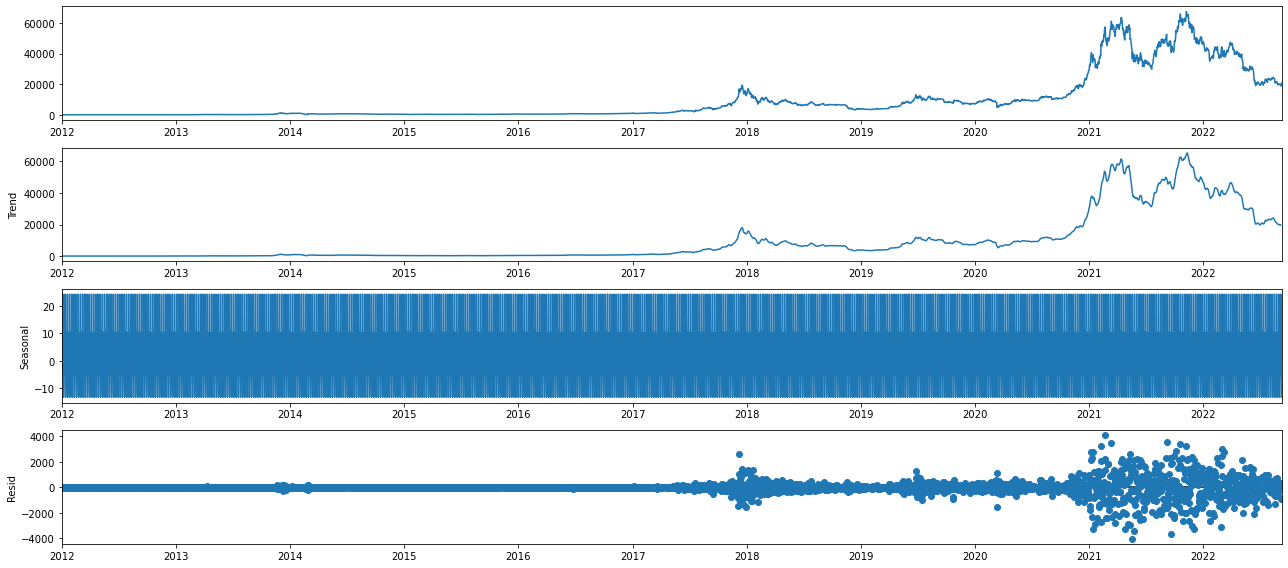

In [42]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(bitcoin_close, model='additive')
fig = decomposition.plot()
plt.show()

For the whole data we see possible seasonality


We'll check for the years 21 and 22 only, so we can see in more detail.

In [43]:
bitcoin_21_22 = bitcoin[bitcoin["date"] >= "2021-01-01"]

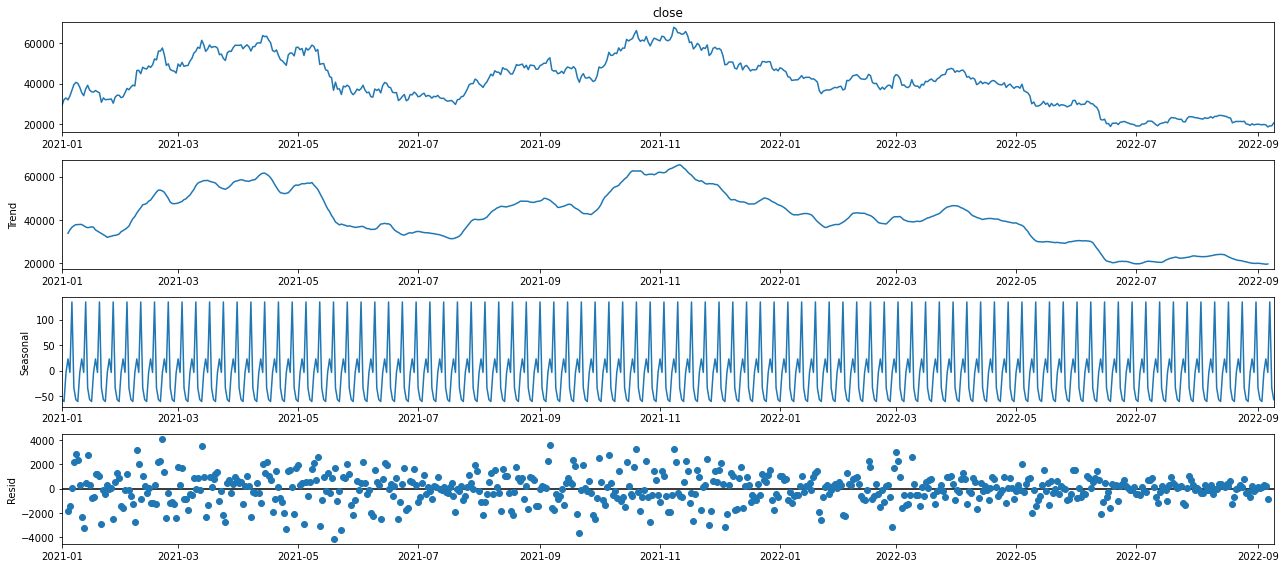

In [44]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(bitcoin_21_22["close"], model='additive')
fig = decomposition.plot()
plt.show()

We don't see Seasonality in this dataset. The Seasonal plot shows a cycle behaviour, but analysing the whole, we can't say there is a pattern in prices.

#### ACF PACF

In the cell below we check for ACF and PACF; autocorrelation and partial autocorrelation.

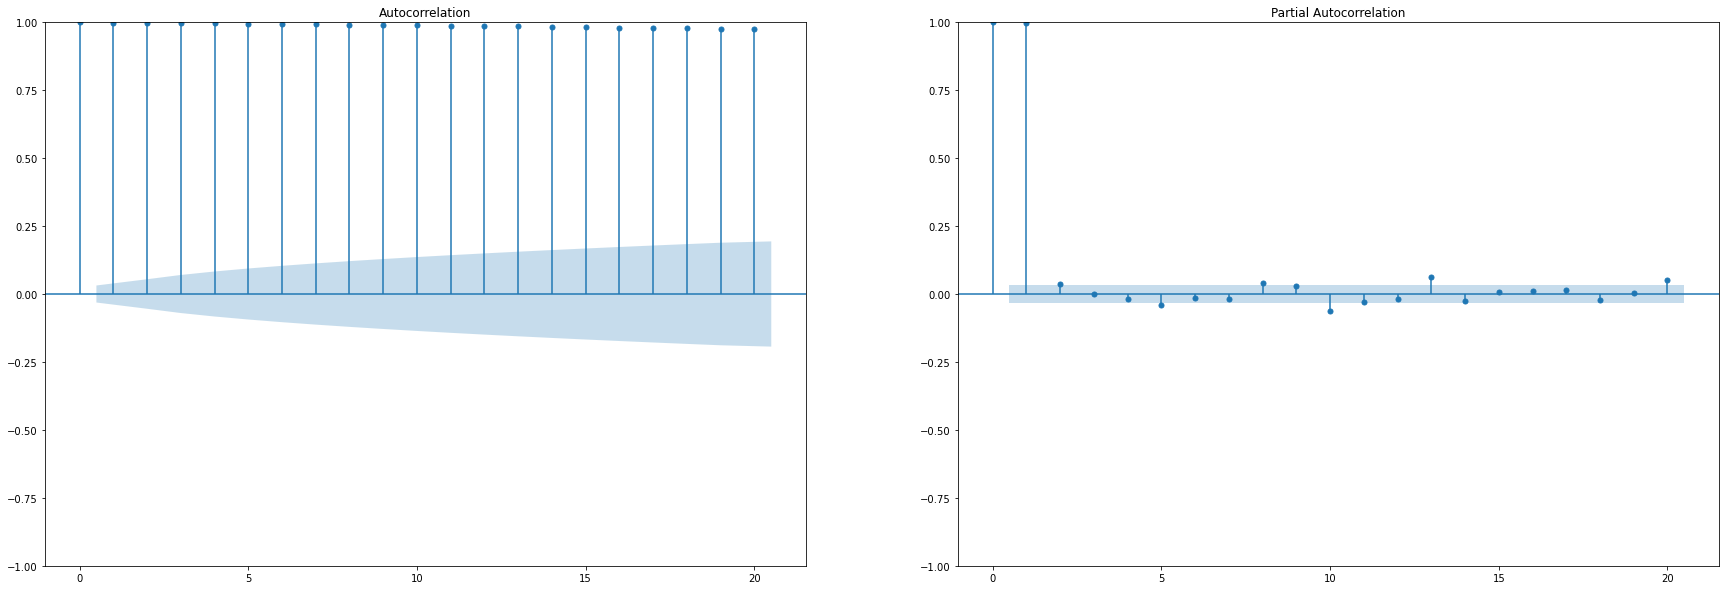

In [45]:
fig, axes = plt.subplots(1, 2, figsize= (30, 10))

fig = sm.graphics.tsa.plot_acf(bitcoin_close['close'],
                               lags = 20,                               
                               ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(bitcoin_close['close'], lags = 20, 
                                ax=axes[1], method = "ywm")

By looking at the plots we see a high Autocorrelation, meaning that each value is highly correlated to the previous one. 

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

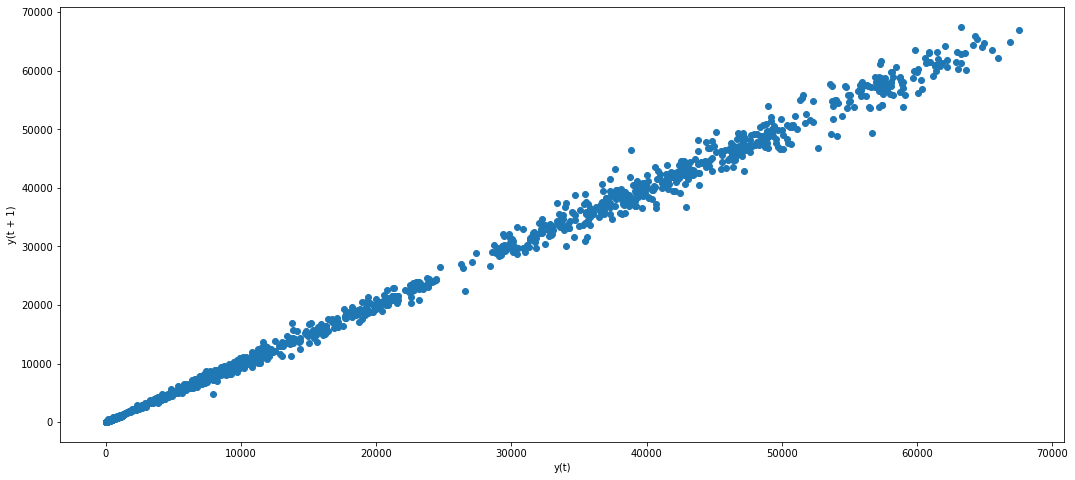

In [46]:
pd.plotting.lag_plot(bitcoin_close["close"])

On the plot above we can almost see a straight line. This tells us that the previous value can be used to predict the next one, to do so, AR(1) model is the one to use

------

### AR

Our first model will be AutoReg. It is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step

Steps to follow:

    - Select data to use
    - Train Test Split
    - Fit model
    - Predict

In [47]:
bitcoin_AR = bitcoin[["date", "close"]]

In [48]:
import math 

max_train = math.ceil(len(bitcoin_AR) * 0.80)  
max_train

3124

In [49]:
train = bitcoin_AR.iloc[:max_train,:]['close']
test  = bitcoin_AR.iloc[max_train:,:]['close']

In [50]:

AR_model_1 = AutoReg(bitcoin_AR["close"], lags = 1)
AR_fit_1 = AR_model_1.fit()

AR_predictions_1 = AR_fit_1.predict(start = len(train), end=len(train)+len(test)-1, dynamic=False)

print(AR_fit_1.params)

const       15.116603
close.L1     0.998966
dtype: float64


C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [51]:
AR_predictions_1

2020-07-21     9168.046734
2020-07-22     9392.714287
2020-07-23     9518.983645
2020-07-24     9604.794863
2020-07-25     9551.649848
                  ...     
2022-09-05    19994.345552
2022-09-06    19787.759292
2022-09-07    18782.099774
2022-09-08    19276.688060
2022-09-09    19312.550955
Freq: D, Length: 781, dtype: float64

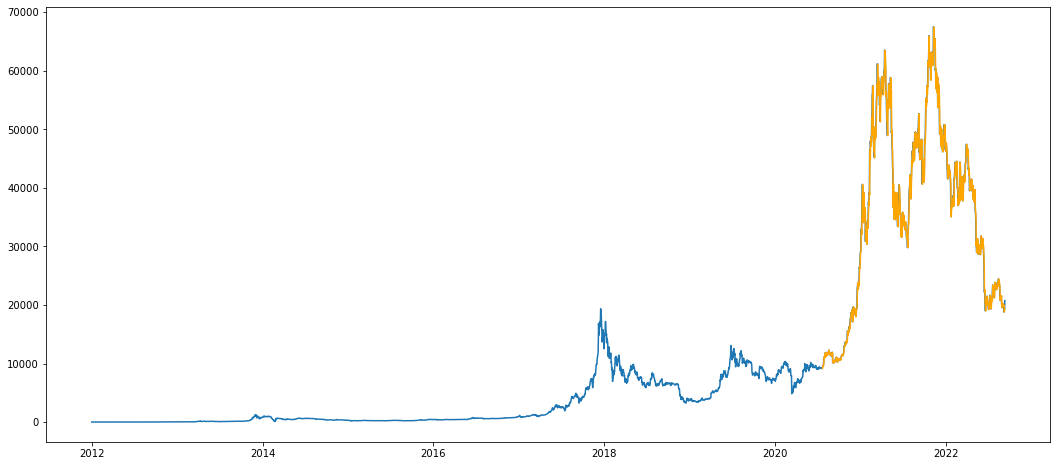

In [52]:
plt.plot(bitcoin_AR["close"])
plt.plot(AR_predictions_1, color='orange')
plt.show()

In [53]:
test = pd.DataFrame(test)
test["AR_predictions_1"] = AR_predictions_1
test["AR_res"] = AR_fit_1.resid
test.head()

close  AR_predictions_1      AR_res
date                                            
2020-07-21  9387.3       9168.046734  219.253266
2020-07-22  9513.7       9392.714287  120.985713
2020-07-23  9599.6       9518.983645   80.616355
2020-07-24  9546.4       9604.794863  -58.394863
2020-07-25  9704.1       9551.649848  152.450152

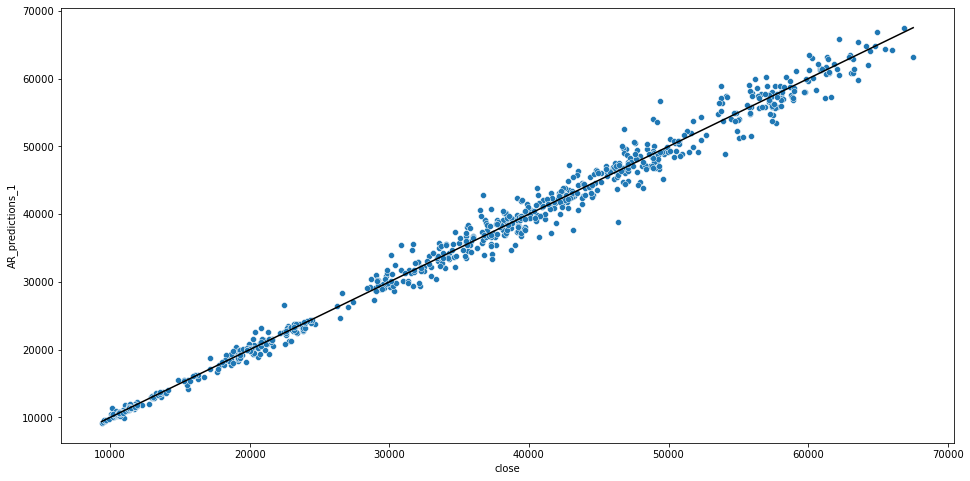

In [54]:
fig, ax = plt.subplots(1,figsize=(16,8))
sns.scatterplot(data = test, y = "AR_predictions_1", x = "close");
sns.lineplot(data= test, x = 'close', y = 'close',color = 'black');
plt.show()

We see that the predicted values follow the patern of the original values 

In [55]:
future_pred = AR_fit_1.predict(start = "2022-09-10", end = "2022-09-29", dynamic=False) 

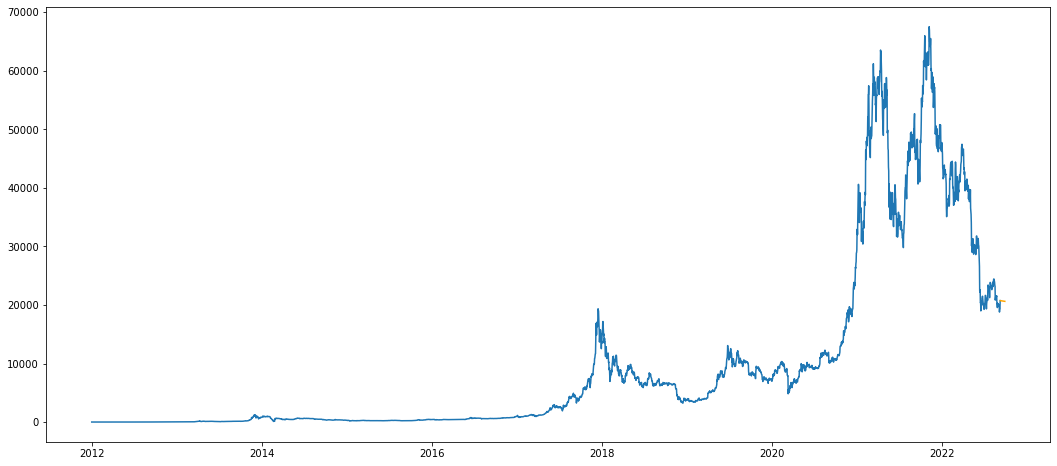

In [56]:
plt.plot(bitcoin_AR["close"])
plt.plot(future_pred, color='orange')
plt.show()

In orange we see the predicted values for bitcoin. The values don't have a great fluctuation, in contrast to the data most near, that could be because about half of the data don't show much fluctuation, in fact we see it almsot as a straigth line. 

#### AR model 2 with fewer data 

In [57]:
bitcoin_21_22 = bitcoin_21_22[["date", "close"]]

In [58]:
max_train = math.ceil(len(bitcoin_21_22) * 0.80)  
max_train

494

In [59]:
train_2 = bitcoin_21_22.iloc[:max_train,:]['close']
test_2 = bitcoin_21_22.iloc[max_train:,:]['close']

In [60]:
AR_model_2 = AutoReg(bitcoin_21_22["close"], lags = 1)
AR_fit_2 = AR_model_2.fit()

AR_predictions_2 = AR_fit_2.predict(start = len(train_2), end=len(train_2)+len(test_2)-1, dynamic=False)

print(AR_fit_2.params)

const       313.833202
close.L1      0.992079
dtype: float64


C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



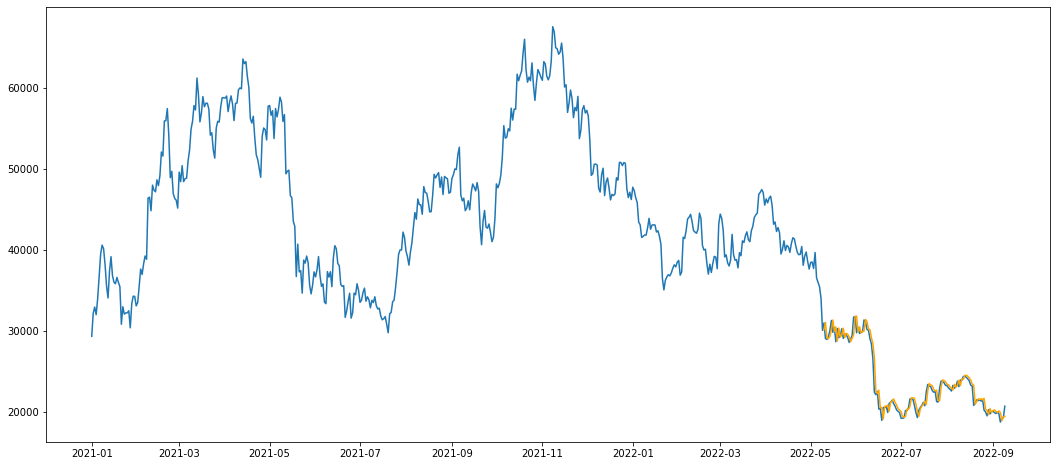

In [61]:
plt.plot(bitcoin_21_22["close"])
plt.plot(AR_predictions_2, color='orange')
plt.show()

In [62]:
future_pred_2 = AR_fit_2.predict(start = "2022-09-10", end = "2022-09-29", dynamic=False) 

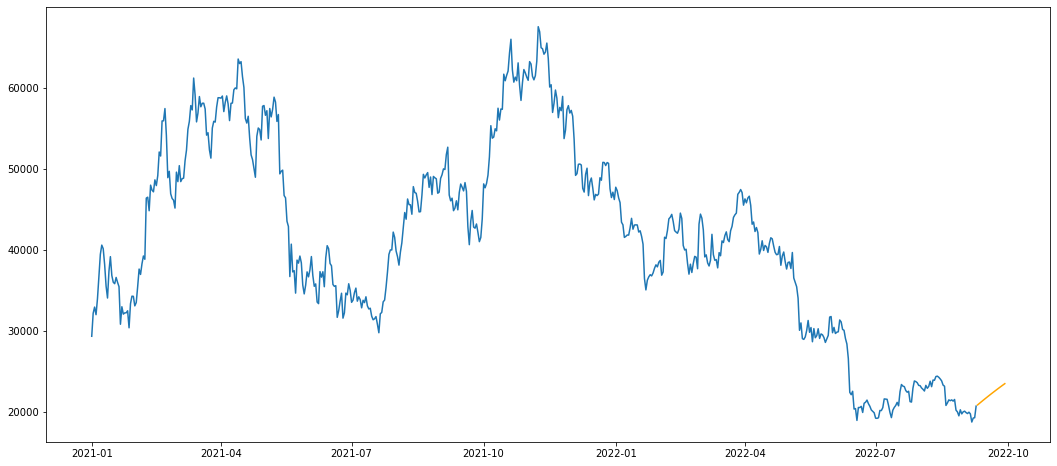

In [63]:
plt.plot(bitcoin_21_22["close"])
plt.plot(future_pred_2, color='orange')
plt.show()

Here, at least, we get a forecast with evolution similar to real fluctuation.

-----

#### ARIMA model

ARIMA is a Time Series model composed by: AR(autoregression), I(integrated) and MA(moving average)

    - The I represents the differencing of raw observations to allow for the time series to become stationary

    - The MA incorporates the dependency between an observation and a residual error from a moving average model applied to  
      lagged observations

Ckecking fot Stationarity between 2021-22

In [64]:
adf_test(bitcoin_21_22["close"])

Results of Dickey-Fuller Test:
Test Statistic                  -1.426083
p-value                          0.569710
#Lags Used                       0.000000
Number of Observations Used    616.000000
Critical Value (1%)             -3.441010
Critical Value (5%)             -2.866243
Critical Value (10%)            -2.569275
dtype: float64


From adf_test we see there is no stationarity. The p-value returned o.57 is higher than the significance level o.o5, and Test Statistic -1.43 is also higher than the Critical Value -2.86. Therefore we accept the null hypothesis: TS has no Stationarity

For ARIMA(p,d,q) model we need Stationary data, in this case we don't have it, thats why we need to apply differencing segment of ARIMA so we can have stationary data. 

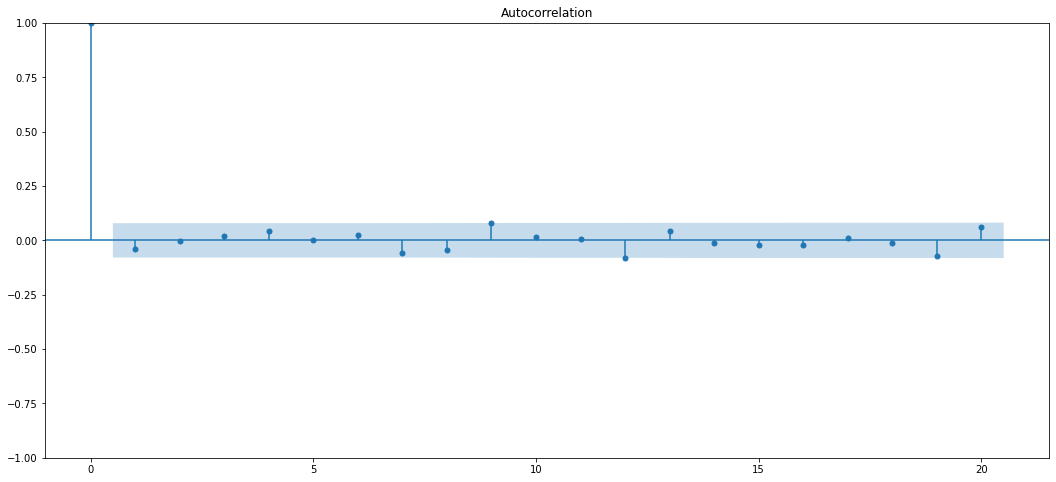

In [65]:
sm.graphics.tsa.plot_acf(bitcoin_21_22['close'].diff()[1:],
                               lags = 20)
plt.show()

We see that differentiating once is enough to deal with lack of stationarity. d = 1.

We also know that p = 1 from the autocorrelation before, and also it was the value we gave to the AR(1) model.
We just need the value for q so we can fit the model. 

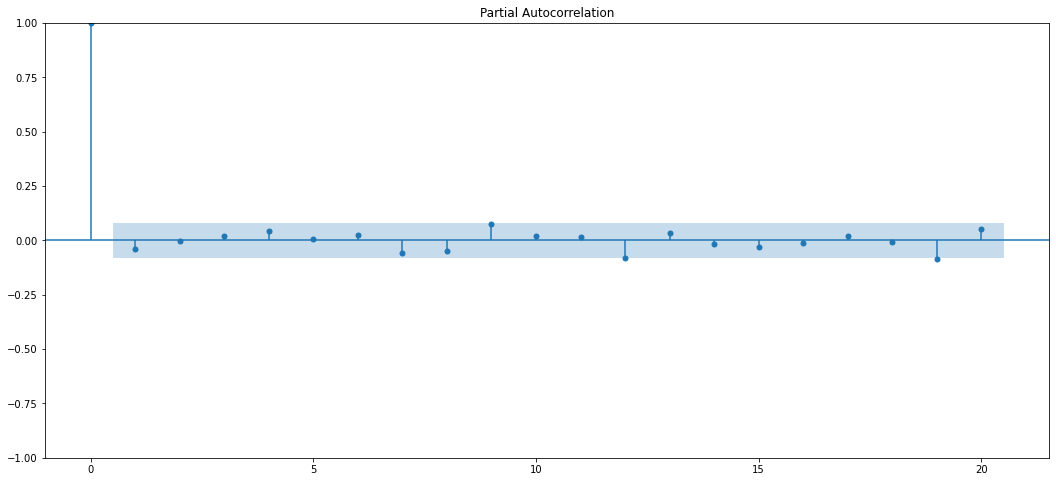

In [66]:
sm.graphics.tsa.plot_pacf(bitcoin_21_22['close'].diff()[1:],
                               lags = 20, method = "ywm")
plt.show()

For this ARIMA the parameters are: 1

In [67]:
ARIMA_model1 = ARIMA(bitcoin_21_22["close"], order = (1, 1, 1), freq ="D")
ARIMA_fit_1 = ARIMA_model1.fit()
ARIMA_fit_1.summary()

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                  617
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5440.221
Date:                Wed, 14 Sep 2022   AIC                          10886.442
Time:                        17:31:10   BIC                          10899.711
Sample:                    01-01-2021   HQIC                         10891.601
                         - 09-09-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0231      9.988     -0.002      0.998     -19.599      19.553
ma.L1          0.0193      9.989      0.002      0.998     -19.560      19.598
sigma2      2.736e+06   1.09e+05     25.168      0.000    2.52e+06    2.95e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):               124.37
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
with open("../models/ARIMA_model1.pkl", "wb") as file:
    pck.dump(ARIMA_model1,file)

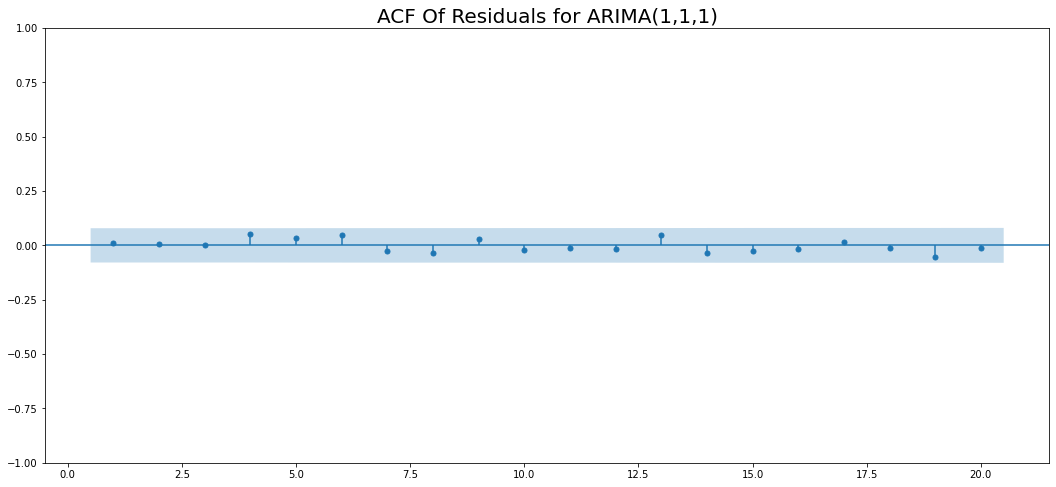

In [69]:
bitcoin_21_22["res_ARIMA_1"] = ARIMA_fit_1.resid
sgt.plot_acf(bitcoin_21_22["res_ARIMA_1"], zero = False, lags = 20)
plt.title("ACF Of Residuals for ARIMA(1,1,1)", size = 20)
plt.show()

In [70]:
ARIMA_predictions_1 = ARIMA_fit_1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)


In [71]:
bitcoin_21_22["ARIMA_predictions_1"] = ARIMA_predictions_1

<AxesSubplot:xlabel='date'>

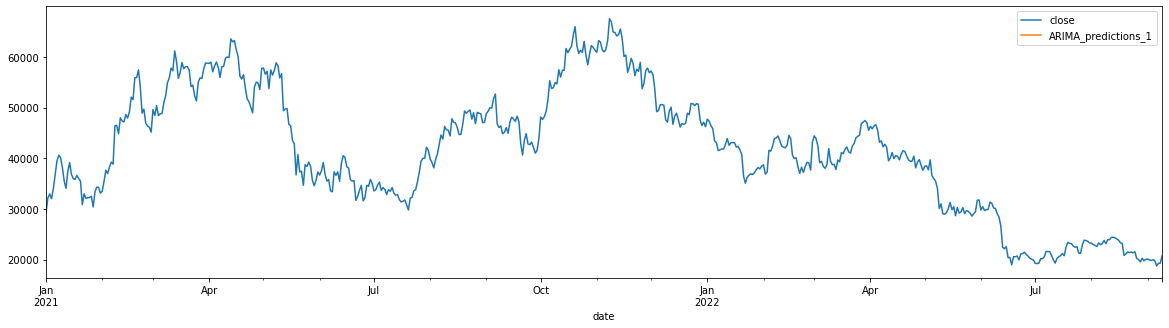

In [73]:
bitcoin_21_22[["close", "ARIMA_predictions_1"]].plot(figsize=(20, 5))

In [74]:
start = datetime.datetime.strptime("2022-09-10", "%Y-%m-%d")
date_list = [start + relativedelta(days = x) for x in range(0,12)]
future_prediction = pd.DataFrame(index = date_list, columns= bitcoin_21_22.columns)
bitcoin_close_pred = pd.concat([bitcoin_21_22, future_prediction])

In [75]:
bitcoin_close_pred

date    close   res_ARIMA_1  ARIMA_predictions_1
2021-01-01 2021-01-01  29359.9  29359.900000                  NaN
2021-01-02 2021-01-02  32193.3   2914.912179                  NaN
2021-01-03 2021-01-03  32958.9    774.764496                  NaN
2021-01-04 2021-01-04  32022.6   -933.575086                  NaN
2021-01-05 2021-01-05  33991.5   1965.298123                  NaN
...               ...      ...           ...                  ...
2022-09-17        NaT      NaN           NaN                  NaN
2022-09-18        NaT      NaN           NaN                  NaN
2022-09-19        NaT      NaN           NaN                  NaN
2022-09-20        NaT      NaN           NaN                  NaN
2022-09-21        NaT      NaN           NaN                  NaN

[629 rows x 4 columns]

In [76]:
len(bitcoin_21_22)

617

In [77]:
bitcoin_close_pred["future_prediction"] = ARIMA_fit_1.predict(start  = 617, end = 629, dynamic=True)

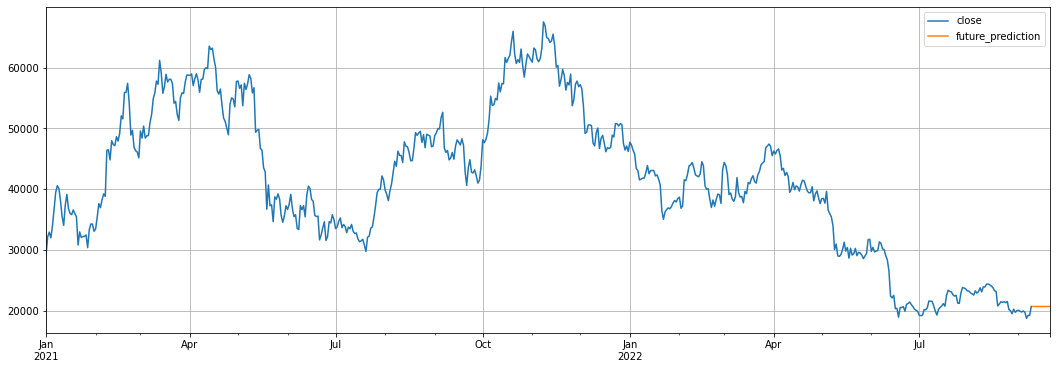

In [79]:
bitcoin_close_pred[["close","future_prediction"]].plot(figsize=(18, 6))
plt.grid(True)

In [80]:
bitcoin_close_pred

date    close   res_ARIMA_1  ARIMA_predictions_1  \
2021-01-01 2021-01-01  29359.9  29359.900000                  NaN   
2021-01-02 2021-01-02  32193.3   2914.912179                  NaN   
2021-01-03 2021-01-03  32958.9    774.764496                  NaN   
2021-01-04 2021-01-04  32022.6   -933.575086                  NaN   
2021-01-05 2021-01-05  33991.5   1965.298123                  NaN   
...               ...      ...           ...                  ...   
2022-09-17        NaT      NaN           NaN                  NaN   
2022-09-18        NaT      NaN           NaN                  NaN   
2022-09-19        NaT      NaN           NaN                  NaN   
2022-09-20        NaT      NaN           NaN                  NaN   
2022-09-21        NaT      NaN           NaN                  NaN   

            future_prediction  
2021-01-01                NaN  
2021-01-02                NaN  
2021-01-03                NaN  
2021-01-04                NaN  
2021-01-05                NaN  
...                       ...  
2022-09-17         20737.5208  
2022-09-18         20737.5208  
2022-09-19         20737.5208  
2022-09-20         20737.5208  
2022-09-21         20737.5208  

[629 rows x 5 columns]

In [81]:
bitcoin_close_pred_22 = bitcoin_close_pred["2022-01-01":]

In the plot below we see in more detail the evolution and prediction of year 2022

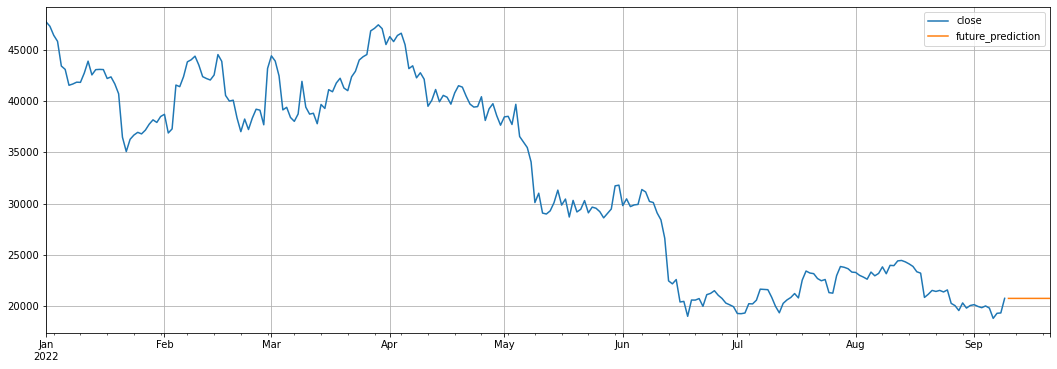

In [82]:
bitcoin_close_pred_22[["close","future_prediction"]].plot(figsize=(18, 6))
plt.grid(True)


##### Second model of ARIMA with wither period of time data, trying to get better results

In [83]:
bitcoin_19_22 = bitcoin[bitcoin["date"] >= "2019-01-01"]
bitcoin_19_22 = bitcoin_19_22[["date", "close"]]

In [84]:
max_train_2 = math.ceil(len(bitcoin_19_22) * 0.80)  
max_train_2

1079

In [85]:
train_2 = bitcoin_19_22.iloc[:max_train_2,:]['close']
test_2  = bitcoin_19_22.iloc[max_train_2:,:]['close']

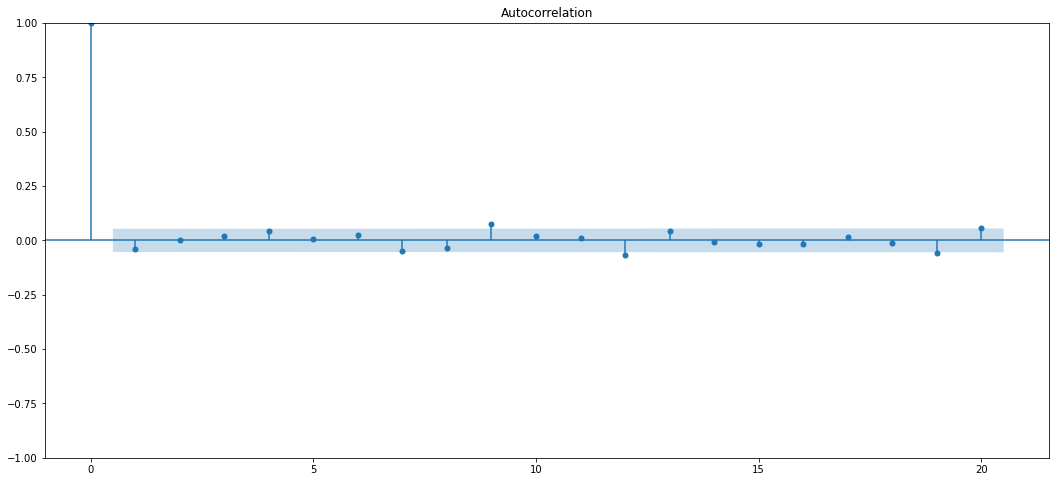

In [86]:
sm.graphics.tsa.plot_acf(bitcoin_19_22['close'].diff()[1:],
                        lags = 20)
plt.show()

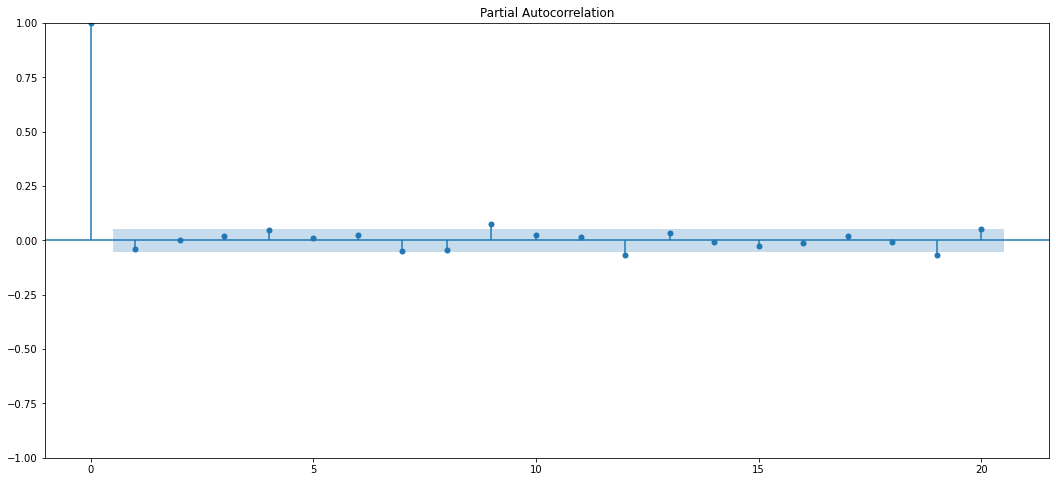

In [87]:
sm.graphics.tsa.plot_pacf(bitcoin_19_22['close'].diff()[1:],
                               lags = 20)
plt.show()

In [88]:
ARIMA_model2 = ARIMA(bitcoin_19_22["close"], order = (2, 1, 4), freq ="D")
ARIMA_fit_2 = ARIMA_model2.fit()
ARIMA_fit_2.summary()

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1348
Model:                 ARIMA(2, 1, 4)   Log Likelihood              -11401.601
Date:                Wed, 14 Sep 2022   AIC                          22817.203
Time:                        17:31:42   BIC                          22853.642
Sample:                    01-01-2019   HQIC                         22830.851
                         - 09-09-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8054      0.037     21.490      0.000       0.732       0.879
ar.L2         -0.9066      0.032    -28.416      0.000      -0.969      -0.844
ma.L1         -0.8501      0.046    -18.570      0.000      -0.940      -0.760
ma.L2          0.9502      0.045     21.130      0.000       0.862       1.038
ma.L3         -0.0254      0.028     -0.901      0.367      -0.081       0.030
ma.L4          0.0289      0.021      1.407      0.159      -0.011       0.069
sigma2      1.338e+06   2.57e+04     52.134      0.000    1.29e+06    1.39e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2706.51
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              17.04   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
with open("../models/ARIMA_model2.pkl", "wb") as file:
    pck.dump(ARIMA_model2,file)

In [90]:
ARIMA_predictions_2 = ARIMA_fit_2.predict(start = len(train_2), end = (len(train_2) + len(test_2) -1), dynamic=False)

In [91]:
bitcoin_19_22["ARIMA_predictions_2"] = ARIMA_predictions_2

<AxesSubplot:xlabel='date'>

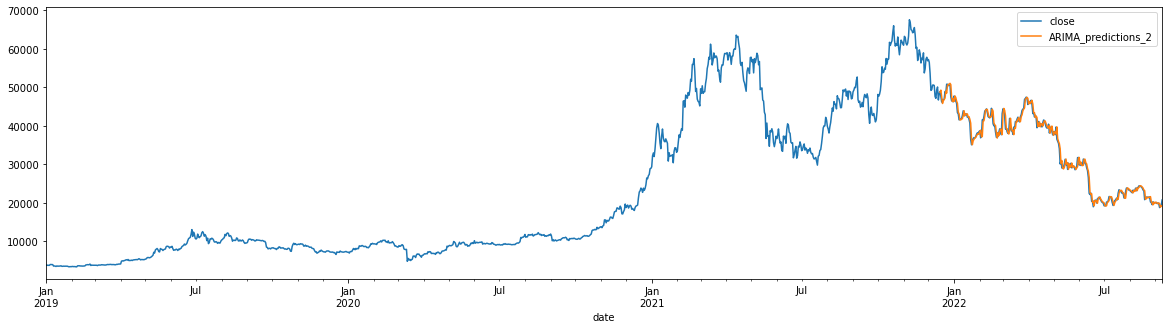

In [92]:
bitcoin_19_22[["close", "ARIMA_predictions_2"]].plot(figsize=(20, 5))

In [93]:
start = datetime.datetime.strptime("2022-09-10", "%Y-%m-%d")
date_list = [start + relativedelta(days = x) for x in range(0,12)]
future_prediction = pd.DataFrame(index = date_list, columns= bitcoin_19_22.columns)
bitcoin_19_22_pred = pd.concat([bitcoin_19_22, future_prediction])

In [94]:
bitcoin_19_22_pred["future_prediction"] = ARIMA_fit_2.predict(start  = 1348, end = 1360, dynamic = False)

In [95]:
bitcoin_19_22_pred

date   close  ARIMA_predictions_2  future_prediction
2019-01-01 2019-01-01  3809.4                  NaN                NaN
2019-01-02 2019-01-02  3873.8                  NaN                NaN
2019-01-03 2019-01-03  3780.1                  NaN                NaN
2019-01-04 2019-01-04  3802.7                  NaN                NaN
2019-01-05 2019-01-05  3785.4                  NaN                NaN
...               ...     ...                  ...                ...
2022-09-17        NaT     NaN                  NaN       20687.095223
2022-09-18        NaT     NaN                  NaN       20779.303504
2022-09-19        NaT     NaN                  NaN       20825.504948
2022-09-20        NaT     NaN                  NaN       20779.119839
2022-09-21        NaT     NaN                  NaN       20699.876337

[1360 rows x 4 columns]

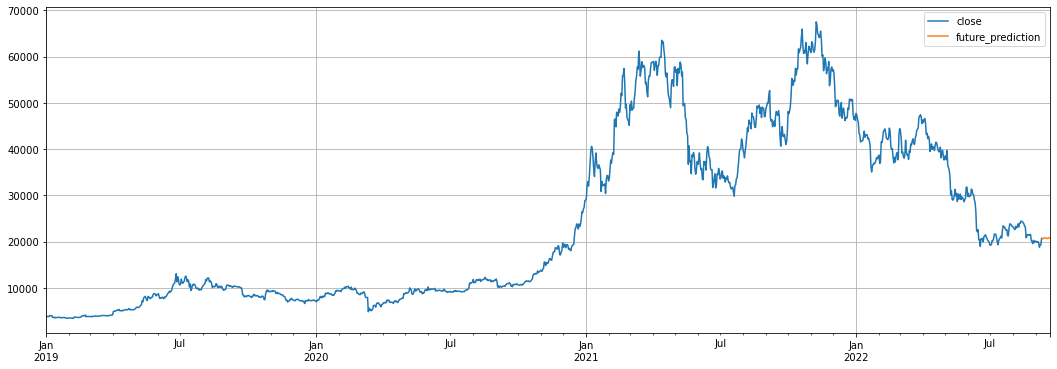

In [96]:
bitcoin_19_22_pred[["close","future_prediction"]].plot(figsize=(18, 6))
plt.grid(True)

In [97]:
test["ARIMA_predictions_1"] = ARIMA_predictions_1
test["res_ARIMA_1"] = ARIMA_fit_1.resid

In [98]:
test.head()

close  AR_predictions_1      AR_res  ARIMA_predictions_1  \
date                                                                    
2020-07-21  9387.3       9168.046734  219.253266                  NaN   
2020-07-22  9513.7       9392.714287  120.985713                  NaN   
2020-07-23  9599.6       9518.983645   80.616355                  NaN   
2020-07-24  9546.4       9604.794863  -58.394863                  NaN   
2020-07-25  9704.1       9551.649848  152.450152                  NaN   

            res_ARIMA_1  
date                     
2020-07-21          NaN  
2020-07-22          NaN  
2020-07-23          NaN  
2020-07-24          NaN  
2020-07-25          NaN

##### Checking MASE for AR and ARIMA

In [99]:
test['1difference'] = np.abs(test['close'] - test['close'].shift(1))
quotient = test['1difference'].mean()
test['q'] = np.abs(test['AR_res'])/quotient
test.head()

close  AR_predictions_1      AR_res  ARIMA_predictions_1  \
date                                                                    
2020-07-21  9387.3       9168.046734  219.253266                  NaN   
2020-07-22  9513.7       9392.714287  120.985713                  NaN   
2020-07-23  9599.6       9518.983645   80.616355                  NaN   
2020-07-24  9546.4       9604.794863  -58.394863                  NaN   
2020-07-25  9704.1       9551.649848  152.450152                  NaN   

            res_ARIMA_1  1difference         q  
date                                            
2020-07-21          NaN          NaN  0.218524  
2020-07-22          NaN        126.4  0.120583  
2020-07-23          NaN         85.9  0.080348  
2020-07-24          NaN         53.2  0.058201  
2020-07-25          NaN        157.7  0.151943

### SKTIME

Now we're going to use Sktime library to select the best possible models for ARIMA

In [100]:
sk_bitcoin = bitcoin[["date", "close"]].set_index("date")

In [101]:
bit_train, bit_test = temporal_train_test_split(sk_bitcoin, test_size = 415)

In [102]:
auto_Arima = auto_arima(sk_bitcoin, start_p = 1, start_q = 1,
                      test='adf', max_p = 5, max_q = 5,          
                      seasonal = False,   
                      start_P = 0, D = None, 
                      trace = True, error_action = 'ignore',  
                      suppress_warnings = True, 
                      stepwise = True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=62209.136, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62209.599, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62207.135, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=62207.152, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62207.825, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=62209.134, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=62211.133, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=62205.375, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=62207.375, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=62207.377, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=62205.393, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=62209.374, Time=0.17 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.769 seconds


In [103]:
auto_Arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3905
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -31100.688
Date:                Wed, 14 Sep 2022   AIC                          62205.375
Time:                        17:31:54   BIC                          62217.915
Sample:                    01-01-2012   HQIC                         62209.826
                         - 09-09-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0338      0.007     -4.697      0.000      -0.048      -0.020
sigma2      4.866e+05   3085.480    157.692      0.000    4.81e+05    4.93e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             90150.75
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):            1746.43   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
sk_pred = auto_Arima.predict(30)

In [105]:
sk_pred = pd.DataFrame(sk_pred)

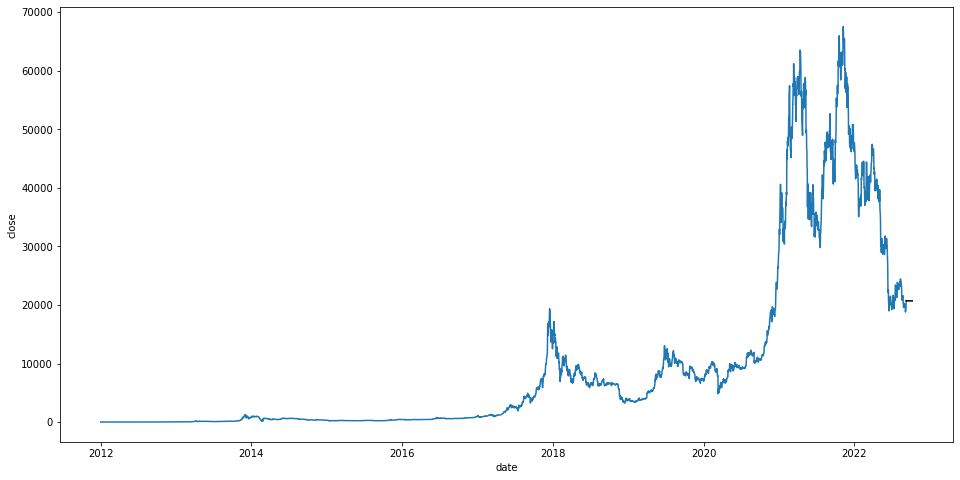

In [106]:
fig, ax = plt.subplots(1, figsize=(16,8))
sns.lineplot(data = sk_bitcoin, y = "close", x = sk_bitcoin.index);
sns.lineplot(data= sk_pred, x = sk_pred.index, y = 0,color = 'black');
plt.show()

## PROPHET 

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data

In [107]:
bitcoin_21_22 = bitcoin[bitcoin["date"] >= "2021-01-01"]

In [108]:
bitcoin_21_22

date      last     open     high      low     vol  var_%  \
date                                                                        
2021-01-01 2021-01-01  29.359,9  28951.7  29627.1  28712.4  100.90   1.42   
2021-01-02 2021-01-02  32.193,3  29359.7  33233.5  29008.0  240.87   9.65   
2021-01-03 2021-01-03  32.958,9  32192.9  34755.9  32029.6  155.21   2.38   
2021-01-04 2021-01-04  32.022,6  33016.6  33587.5  28204.5  255.27  -2.84   
2021-01-05 2021-01-05  33.991,5  32015.4  34414.7  30010.5  202.13   6.15   
...               ...       ...      ...      ...      ...     ...    ...   
2022-09-05 2022-09-05  19.793,1  19999.9  20042.9  19650.7  238.71  -1.03   
2022-09-06 2022-09-06  18.786,4  19793.4  20169.3  18723.3  402.43  -5.09   
2022-09-07 2022-09-07  19.281,5  18786.3  19445.9  18548.4  319.10   2.64   
2022-09-08 2022-09-08  19.317,4  19281.5  19444.7  19034.5  291.43   0.19   
2022-09-09 2022-09-09  20.742,8  19318.8  20743.7  19294.1  359.40   7.38   

              close  
date                 
2021-01-01  29359.9  
2021-01-02  32193.3  
2021-01-03  32958.9  
2021-01-04  32022.6  
2021-01-05  33991.5  
...             ...  
2022-09-05  19793.1  
2022-09-06  18786.4  
2022-09-07  19281.5  
2022-09-08  19317.4  
2022-09-09  20742.8  

[617 rows x 8 columns]

In [109]:
bitcoin_21_22_prophet = bitcoin_21_22[["close", "date"]].rename(columns = {"close": 'y', "date": "ds"})

In [110]:
bitcoin_21_22_prophet.head()

y         ds
date                          
2021-01-01  29359.9 2021-01-01
2021-01-02  32193.3 2021-01-02
2021-01-03  32958.9 2021-01-03
2021-01-04  32022.6 2021-01-04
2021-01-05  33991.5 2021-01-05

In [111]:
bitcoin_fbp = Prophet()
with open("../models/bitcoin_fbp.pkl", "wb") as file:
    pck.dump(bitcoin_fbp,file)

bitcoin_fbp.fit(bitcoin_21_22_prophet)

bitcoin_prophet = bitcoin_fbp.make_future_dataframe(periods = 120, freq = "D")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


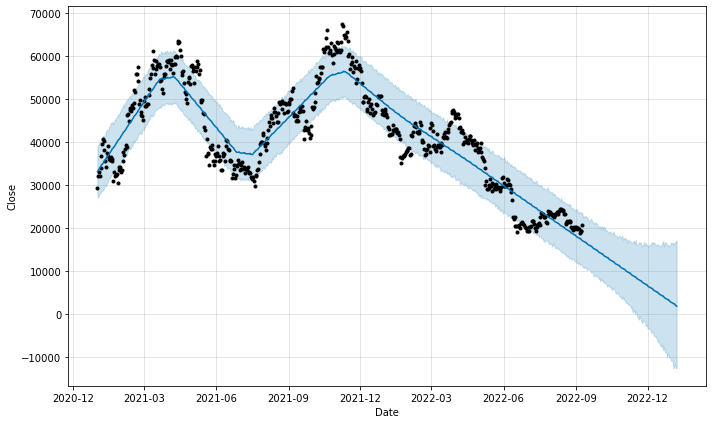

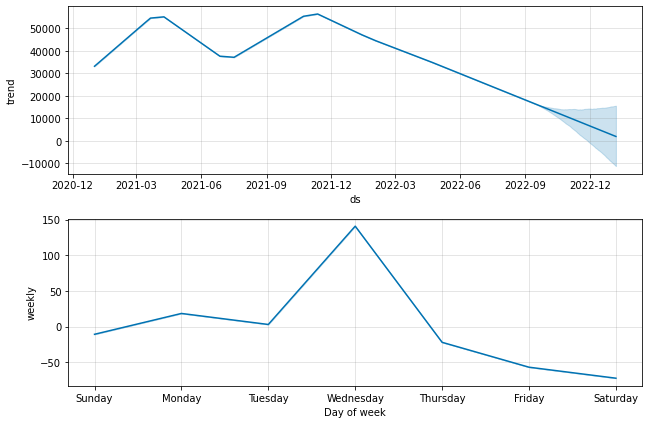

In [112]:
bitcoin_prophet_future = bitcoin_fbp.predict(bitcoin_prophet)

bitcoin_fbp.plot(bitcoin_prophet_future, xlabel = 'Date', ylabel = 'Close')
fig = bitcoin_fbp.plot_components(bitcoin_prophet_future)
plt.show()

In the first plot: 
    
    - Black dots show the real data that we have in the original Dataset 
    
    - Blue line is the forecasted data, the data predicted. 

As we can see the predictions show that the price of Bitcoin will drop in the following months

In [113]:
len(bitcoin_21_22)

617

In [114]:
fbp_cv = cross_validation(bitcoin_fbp, initial = '617', period = '120 days', horizon = '365 days',
                         parallel="processes")
fbp_cv.head()

INFO:prophet:Making 3 forecasts with cutoffs between 2021-01-12 00:00:00 and 2021-09-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001C0B52C6610>


ds          yhat    yhat_lower    yhat_upper        y     cutoff
0 2021-01-13  42394.139714  40117.051375  44589.214061  37382.2 2021-01-12
1 2021-01-14  45059.206766  42945.901227  47240.002481  39175.7 2021-01-12
2 2021-01-15  43384.595612  41235.842455  45811.075329  36845.8 2021-01-12
3 2021-01-16  44575.896872  42298.241120  46782.860742  36019.5 2021-01-12
4 2021-01-17  43977.686854  41700.892668  45918.458949  35839.6 2021-01-12

In [115]:
#checking performance metrics for ERROR

bitcoin_prophet_future_pm = performance_metrics(fbp_cv)

In [116]:
bitcoin_prophet_future_pm

horizon           mse           rmse            mae      mape     mdape  \
0    37 days  2.343130e+08   15307.284520   13986.622496  0.358702  0.366443   
1    38 days  2.391222e+08   15463.577724   14145.978054  0.362630  0.374419   
2    39 days  2.436844e+08   15610.393994   14285.483426  0.365950  0.374974   
3    40 days  2.488141e+08   15773.843074   14426.150844  0.370016  0.377531   
4    41 days  2.537633e+08   15929.951067   14573.247927  0.373874  0.388532   
..       ...           ...            ...            ...       ...       ...   
324 361 days  2.940725e+10  171485.420519  134282.931618  3.899492  5.286174   
325 362 days  2.962605e+10  172122.190571  134893.125621  3.940548  5.306082   
326 363 days  2.982809e+10  172708.099633  135466.778343  3.977202  5.317301   
327 364 days  3.003689e+10  173311.548205  136062.320719  4.013638  5.326265   
328 365 days  3.026983e+10  173982.279663  136679.237329  4.044118  5.335399   

        smape  coverage  
0    0.293127  0.100917  
1    0.295860  0.110092  
2    0.298098  0.119266  
3    0.300554  0.128440  
4    0.302994  0.137615  
..        ...       ...  
324  1.038481  0.333333  
325  1.044393  0.333333  
326  1.049876  0.333333  
327  1.055732  0.333333  
328  1.060956  0.333333  

[329 rows x 8 columns]

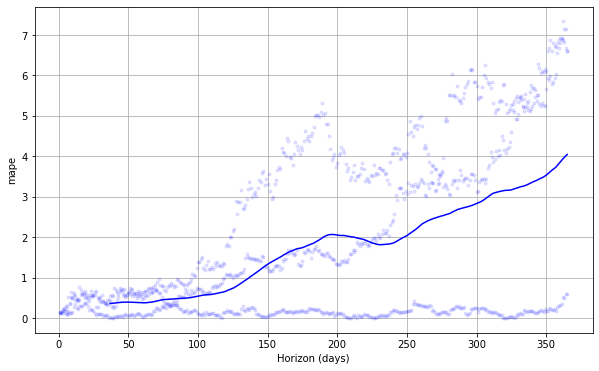

In [117]:
fig = plot_cross_validation_metric(fbp_cv, metric = 'mape')

Here we see error metric MAPE through the days prediccted in the future. The blue line represents the MAPE that tends to increase as the time goes by. 

##### New prophet facebook setting a different seasonality and longer period of time 

In [118]:
bitcoin_17_22_prophet = bitcoin[["date", "close"]].rename(columns = {"close": 'y', "date": "ds"})

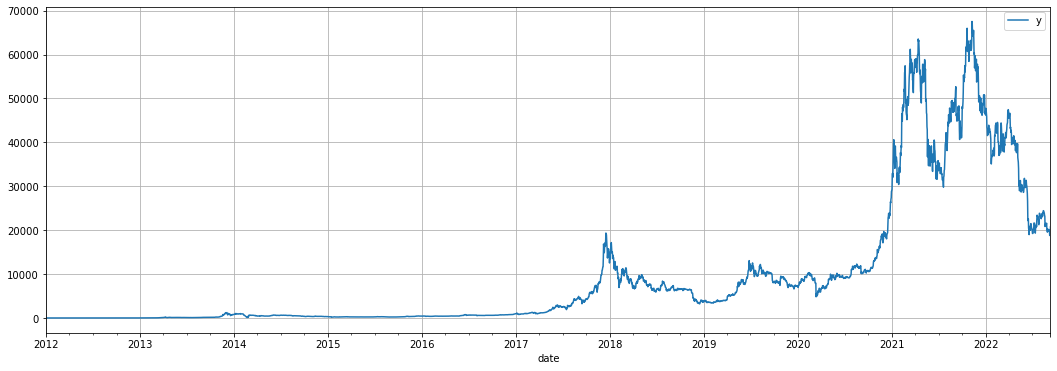

In [119]:
bitcoin_17_22_prophet[["y"]].plot(figsize=(18, 6))
plt.grid(True)

In [120]:
bitcoin[bitcoin["date"] > "2021-11-01"].head(30)

date      last     open     high      low     vol  var_%  \
date                                                                        
2021-11-02 2021-11-02  63.221,7  60912.2  64256.4  60651.5   65.26   3.79   
2021-11-03 2021-11-03  62.918,5  63223.5  63508.6  60883.0   61.05  -0.48   
2021-11-04 2021-11-04  61.412,6  62915.4  63077.6  60742.9   49.91  -2.39   
2021-11-05 2021-11-05  60.974,3  61411.5  62560.3  60742.4   44.46  -0.71   
2021-11-06 2021-11-06  61.483,9  60973.2  61543.2  60093.6   34.89   0.84   
2021-11-07 2021-11-07  63.273,2  61483.8  63273.2  61347.2   34.34   2.91   
2021-11-08 2021-11-08  67.527,9  63276.4  67763.3  63276.4   81.08   6.72   
2021-11-09 2021-11-09  66.904,4  67528.7  68493.3  66334.9   66.13  -0.92   
2021-11-10 2021-11-10  64.932,6  66942.6  68990.6  62951.3   96.21  -2.95   
2021-11-11 2021-11-11  64.806,7  64922.8  65583.3  64121.9   50.37  -0.19   
2021-11-12 2021-11-12  64.134,5  64782.6  65449.7  62309.7   63.27  -1.04   
2021-11-13 2021-11-13  64.398,6  64133.3  64906.0  63381.4   30.34   0.41   
2021-11-14 2021-11-14  65.508,2  64397.2  65508.2  63608.3   33.98   1.72   
2021-11-15 2021-11-15  63.597,9  65514.9  66311.2  63439.5   53.53  -2.92   
2021-11-16 2021-11-16  60.089,1  63605.1  63605.6  58655.9  115.36  -5.52   
2021-11-17 2021-11-17  60.367,8  60074.2  60814.5  58531.9   73.93   0.46   
2021-11-18 2021-11-18  56.955,3  60368.2  60936.9  56524.4  100.37  -5.65   
2021-11-19 2021-11-19  58.083,4  56908.3  58335.9  55626.3   74.44   1.98   
2021-11-20 2021-11-20  59.717,6  58080.8  59854.6  57435.3   44.53   2.81   
2021-11-21 2021-11-21  58.714,3  59724.0  60002.6  58528.3   40.98  -1.68   
2021-11-22 2021-11-22  56.308,8  58719.7  59288.3  55656.8   76.45  -4.10   
2021-11-23 2021-11-23  57.573,2  56304.8  57855.1  55542.5   72.48   2.25   
2021-11-24 2021-11-24  57.171,7  57559.4  57697.4  55910.6   56.68  -0.70   
2021-11-25 2021-11-25  58.935,1  57167.1  59387.3  57029.8   56.79   3.08   
2021-11-26 2021-11-26  53.730,9  58937.3  59151.1  53533.5  104.03  -8.83   
2021-11-27 2021-11-27  54.765,9  53747.2  55280.3  53654.3   40.71   1.93   
2021-11-28 2021-11-28  57.291,5  54758.0  57392.3  53448.3   49.28   4.61   
2021-11-29 2021-11-29  57.794,8  57288.1  58855.2  56726.7   58.65   0.88   
2021-11-30 2021-11-30  56.882,9  57795.2  59174.4  55936.9   73.66  -1.58   
2021-12-01 2021-12-01  57.210,3  56891.7  59064.3  56496.5   66.75   0.58   

              close  
date                 
2021-11-02  63221.7  
2021-11-03  62918.5  
2021-11-04  61412.6  
2021-11-05  60974.3  
2021-11-06  61483.9  
2021-11-07  63273.2  
2021-11-08  67527.9  
2021-11-09  66904.4  
2021-11-10  64932.6  
2021-11-11  64806.7  
2021-11-12  64134.5  
2021-11-13  64398.6  
2021-11-14  65508.2  
2021-11-15  63597.9  
2021-11-16  60089.1  
2021-11-17  60367.8  
2021-11-18  56955.3  
2021-11-19  58083.4  
2021-11-20  59717.6  
2021-11-21  58714.3  
2021-11-22  56308.8  
2021-11-23  57573.2  
2021-11-24  57171.7  
2021-11-25  58935.1  
2021-11-26  53730.9  
2021-11-27  54765.9  
2021-11-28  57291.5  
2021-11-29  57794.8  
2021-11-30  56882.9  
2021-12-01  57210.3

In [121]:
bitcoin_fbp_2 = Prophet(weekly_seasonality=False)
bitcoin_fbp_2.add_seasonality(name='monthly', period=30.5, fourier_order=5)
with open("../models/bitcoin_fbp_2.pkl", "wb") as file:
    pck.dump(bitcoin_fbp,file)

bitcoin_fbp_2.fit(bitcoin_17_22_prophet)
bitcoin_prophet_2 = bitcoin_fbp_2.make_future_dataframe(periods = 30, freq = "D")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


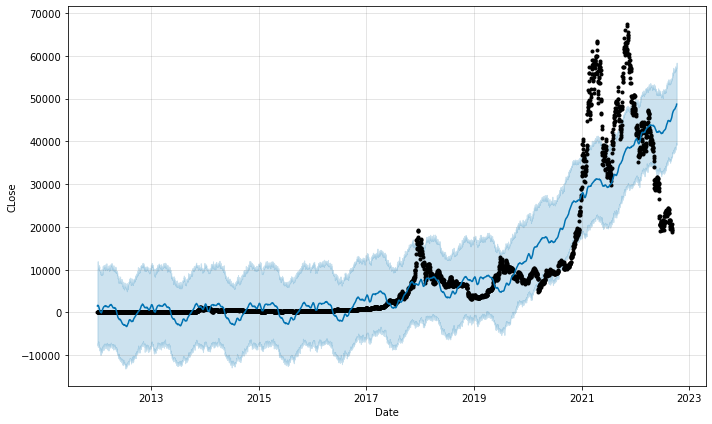

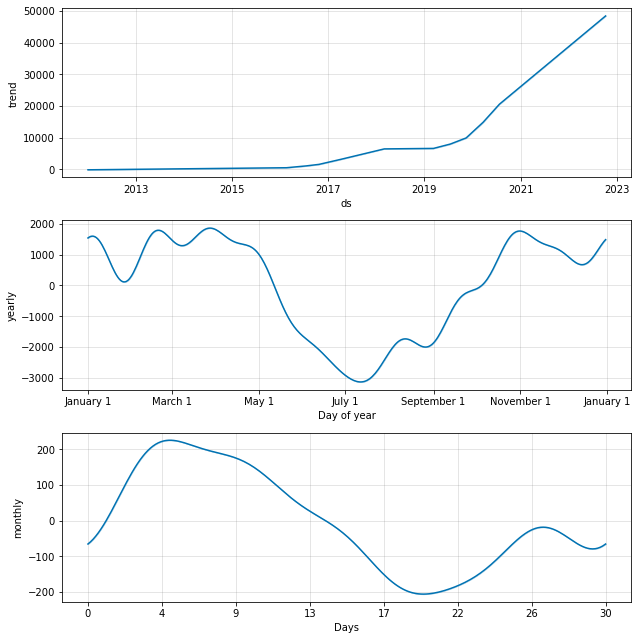

In [122]:
bitcoin_prophet_future_2 = bitcoin_fbp_2.predict(bitcoin_prophet_2)

bitcoin_fbp_2.plot(bitcoin_prophet_future_2, xlabel = 'Date', ylabel = 'CLose')
fig = bitcoin_fbp_2.plot_components(bitcoin_prophet_future_2)
plt.show()

Here we get a better prediction, it doesn't perform well when predicting peaks, but it follows tendencies pretty well. 
So far is the best we got

In [123]:
cutoffs = pd.to_datetime(["2017-12-16", "2019-09-01", "2021-04-15", "2021-07-20"])

fbp_cv_2 = cross_validation(bitcoin_fbp_2, cutoffs = cutoffs, initial = '2078', period = '30 days', horizon = '365 days',
                         parallel="processes")
fbp_cv_2.head()

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001C0B4FA8280>


ds         yhat   yhat_lower   yhat_upper        y     cutoff
0 2017-12-17  7666.810195  6617.433478  8799.736807  19065.7 2017-12-16
1 2017-12-18  7566.530367  6512.725981  8613.656123  18972.3 2017-12-16
2 2017-12-19  7484.965711  6428.763977  8549.965564  17523.7 2017-12-16
3 2017-12-20  7419.130661  6323.276490  8458.955538  16462.0 2017-12-16
4 2017-12-21  7355.998522  6251.260071  8379.073933  15632.1 2017-12-16

In [124]:
bitcoin_prophet_future_pm_2 = performance_metrics(fbp_cv_2)

In [125]:
bitcoin_prophet_future_pm_2

horizon           mse          rmse           mae      mape     mdape  \
0    37 days  1.343724e+08  11591.911932   8712.158615  0.336546  0.398857   
1    38 days  1.278375e+08  11306.525374   8461.591776  0.330691  0.375118   
2    39 days  1.225796e+08  11071.565620   8266.343470  0.326054  0.364343   
3    40 days  1.182390e+08  10873.777194   8091.199792  0.321567  0.360284   
4    41 days  1.139366e+08  10674.106965   7920.280976  0.317324  0.346166   
..       ...           ...           ...           ...       ...       ...   
324 361 days  3.882474e+08  19703.994898  14383.741812  1.102154  0.877715   
325 362 days  3.932776e+08  19831.227648  14493.417466  1.124572  0.736776   
326 363 days  3.967872e+08  19919.517565  14575.354114  1.145140  0.571956   
327 364 days  3.988676e+08  19971.668999  14652.060857  1.163774  0.747029   
328 365 days  3.999633e+08  19999.081786  14709.561858  1.180549  0.913449   

        smape  coverage  
0    0.426654  0.226027  
1    0.418471  0.232877  
2    0.411794  0.236301  
3    0.405360  0.236301  
4    0.399271  0.236301  
..        ...       ...  
324  0.686413  0.150685  
325  0.694062  0.150685  
326  0.700876  0.150685  
327  0.707345  0.147260  
328  0.713079  0.143836  

[329 rows x 8 columns]

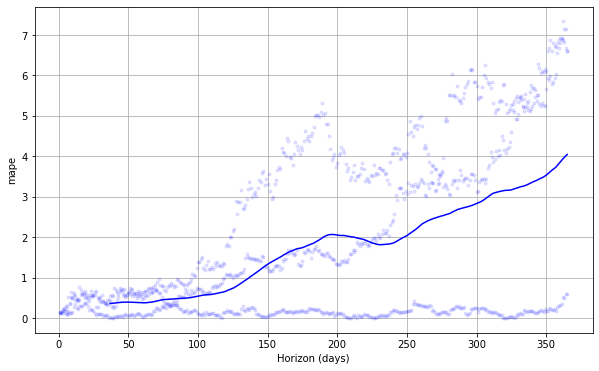

In [126]:
fig = plot_cross_validation_metric(fbp_cv, metric = 'mape')

In [127]:
prophet_future_values = bitcoin_prophet_future_2[bitcoin_prophet_future_2["ds"] > "2022-09-09"]

In [128]:
prophet_future_values = prophet_future_values[["ds", "yhat"]].rename(columns = {"yhat": 'close', "ds": "date"})

In [129]:
prophet_future_values = prophet_future_values.set_index("date")

In [130]:
prophet_future_values.insert(loc = 0, column = "date", value = prophet_future_values.index)

In [131]:
prophet_future_values.head()

date         close
date                               
2022-09-10 2022-09-10  46402.452545
2022-09-11 2022-09-11  46542.098796
2022-09-12 2022-09-12  46658.336121
2022-09-13 2022-09-13  46768.913342
2022-09-14 2022-09-14  46879.311289

In [132]:
fig = px.line(prophet_future_values, x = "date", y = "close")
fig.show()

In this plot we see the performance of the model forecasting the next 30 days

## Neuronal networks

In [133]:
nn_bitcoin = bitcoin[["close"]]

In [134]:
max_train = math.ceil(len(bitcoin_AR) * 0.50)  
max_train

1953

In [135]:
train = nn_bitcoin.iloc[:max_train,:]['close']
test  = nn_bitcoin.iloc[max_train:,:]['close']

In [136]:
scaler = StandardScaler()

scaled_close = scaler.fit_transform(nn_bitcoin)

In [137]:
scaled_close = scaled_close.reshape(-1, 1)

In [138]:
def create_sequences(data, seq_size = 1):
    d = []

    for index in range(len(data) - seq_size):
        d.append(data[index: index + seq_size])

    return np.array(d)

def preprocess(data_raw, seq_size, train_split):

    data = create_sequences(data_raw, seq_size)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

In [139]:
seq_size = 5
X_train, y_train, X_test, y_test = preprocess(scaled_close, seq_size, train_split = 0.85)

In [140]:
tf.random.set_seed(1)

dropout = 0.2

nn_lstm = Sequential()

nn_lstm.add(LSTM(units = 14, input_shape = (None, 1), activation = "tanh", recurrent_activation = "sigmoid"))
nn_lstm.add(Dropout(rate = dropout))

nn_lstm.add(Dense(units=1))

nn_lstm.compile(loss = "mse", optimizer = "adam")

nn_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14)                896       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 1)                 15        
                                                                 
Total params: 911
Trainable params: 911
Non-trainable params: 0
_________________________________________________________________


In [141]:
with open("../models/nn_lstm.pkl", "wb") as file:
    pck.dump(nn_lstm,file)

INFO:tensorflow:Assets written to: ram://4f2b356f-6e48-42c3-a06f-cf7dc2b3a5af/assets


INFO:tensorflow:Assets written to: ram://4f2b356f-6e48-42c3-a06f-cf7dc2b3a5af/assets


In [142]:
future_close = nn_lstm.fit(X_train, y_train,
                         batch_size = 30, epochs=30,
                         validation_split=0.1)

Epoch 1/30
100/100 [==============================] - 3s 8ms/step - loss: 0.1486 - val_loss: 0.5116
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0244 - val_loss: 0.3558
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0110 - val_loss: 0.2603
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.2230
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.2021
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.1829
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.1654
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.1511
Epoch 9/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.1382
Epoch 10/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.1257

<AxesSubplot:>

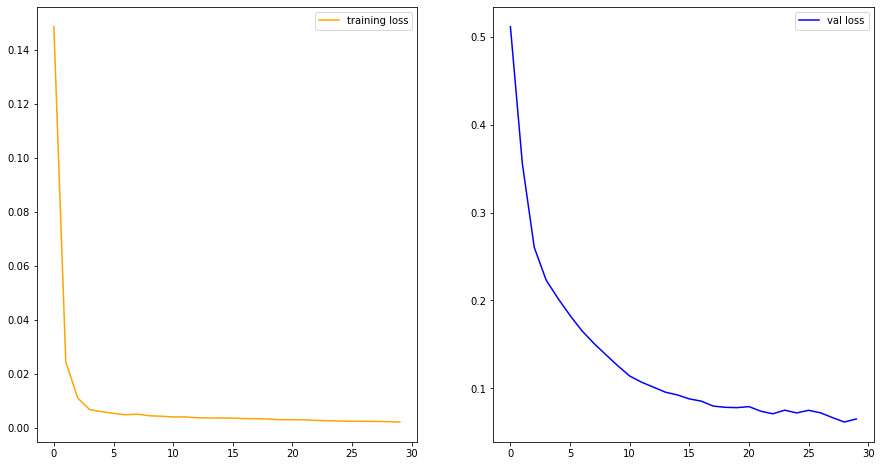

In [143]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 8))
sns.lineplot(x = nn_lstm.history.epoch,
             y = nn_lstm.history.history["loss"],
             color = "orange", label = "training loss", ax = ax1)
sns.lineplot(x = nn_lstm.history.epoch,
             y = nn_lstm.history.history["val_loss"],
             color = "blue", label = "val loss", ax = ax2)

In [144]:
close_train = scaler.inverse_transform(nn_lstm.predict(X_train))
close_test = scaler.inverse_transform(nn_lstm.predict(X_test))

19/19 [==============================] - 0s 2ms/step


In [145]:
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

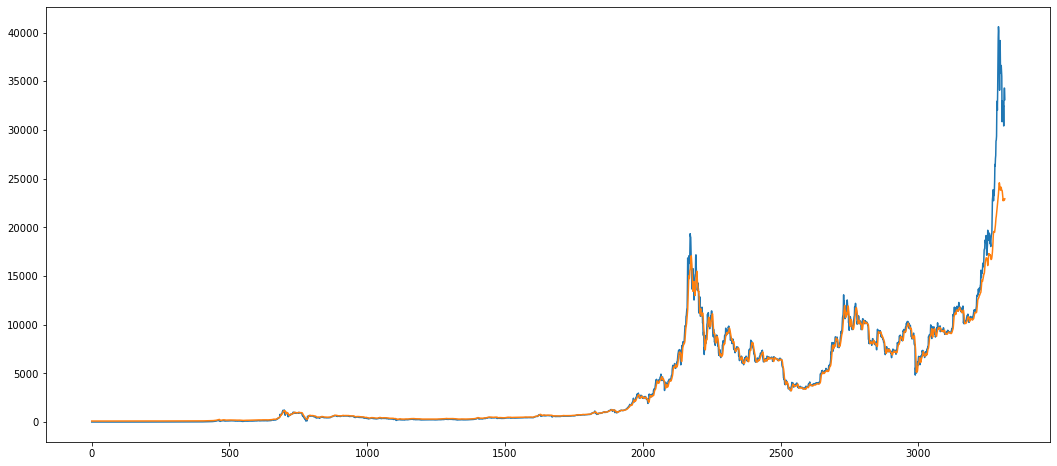

In [146]:
plt.plot(y_train)
plt.plot(close_train)

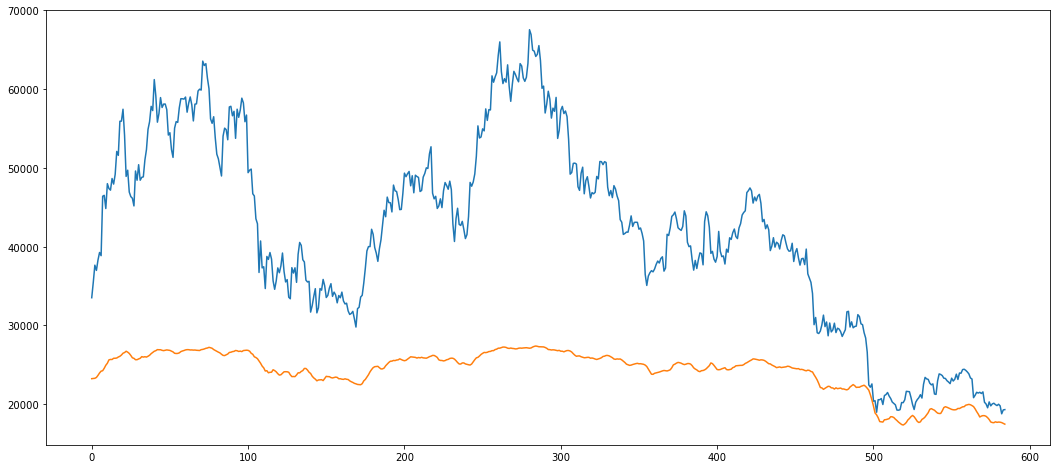

In [147]:
plt.plot(y_test)
plt.plot(close_test)

## Looking for economic indicators of incluence in Bitcoin pricing